<a href="https://colab.research.google.com/github/cs19m047/Easy-deep-learning-with-Keras/blob/master/Assignment2(DL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [241]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import re

In [242]:
images=[]
classes={}
label=[]
i=0
path='/content/sample_data/Dataset_2/'
for file in os.listdir(path):
  class_name=os.path.splitext(file)[0]
  classes[str(class_name)]=i
  images.append(np.array(pd.read_csv(path+file,header=None)))
  label.append(np.full((len(images[i]),1),i))
  i+=1

In [243]:
X=images[0]
Y=label[0]
for j in range(1,i):
    X=np.concatenate((X,images[j]),axis=0)
    Y=np.concatenate((Y,label[j]),axis=0)

In [244]:
Zipped_data=list(zip(X,Y))
np.random.shuffle(Zipped_data)
X_shuffled,label_shuffled=zip(*Zipped_data)

In [245]:
X_normalized=np.array(X_shuffled)/255

In [250]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.parallel
import torch.optim as optim
import pandas as pd
import torch.utils.data
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns

In [251]:
X_=torch.FloatTensor(X_normalized)
labels = torch.tensor(np.array(label_shuffled).reshape(len(label_shuffled,)))

In [252]:
train_data = TensorDataset(torch.tensor(X_), torch.tensor(labels)) 
trainset = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [253]:
class RBM:
    def __init__(self, nv, nh):
        self.wts = torch.FloatTensor(np.random.randn(nv,nh)) * np.sqrt(6.0 / (nv+nh)) 
        self.bv = torch.ones(1, nv) * 0.5
        self.bh = torch.zeros(1, nh)

    def sampling_v(self, h0):
        v1 = torch.sigmoid(torch.mm(h0, self.wts.T) + self.bv)
        v1b = torch.bernoulli(v1)
        return v1, v1b
  
    def sampling_h(self, v0):
        h1 = torch.sigmoid(torch.mm(v0, self.wts) + self.bh)
        h1b = torch.bernoulli(h1)
        return h1, h1b
    
    def update_parameters(self,alpha,vdata,hdata,vmodel,hmodel):
        self.wts+=alpha[0] * (torch.mm(vdata.T, hdata) - torch.mm(vmodel.T, hmodel))
        self.bv+=alpha[1] * torch.sum(vdata - vmodel, 0)
        self.bh+=alpha[2] * torch.sum(hdata - hmodel, 0)
    
    
    def train(self,epochs,k,alpha,stack_rbm_no):
        for epoch in tqdm(range(epochs)):
              for _, batch in (enumerate(trainset)):
                    vdata, _ = batch
                    if stack_rbm_no==1:
                        hdata, hdata_b = self.sampling_h(torch.bernoulli(vdata))

                    elif stack_rbm_no==2:
                        vdata, vdata_b = rbm_1.sampling_h(torch.bernoulli(vdata))
                        hdata, hdata_b = self.sampling_h(vdata_b)
                        
                    elif stack_rbm_no==3:
                        vdata, vdata_b = rbm_1.sampling_h(torch.bernoulli(vdata))
                        vdata, vdata_b = rbm_2.sampling_h(vdata_b)
                        hdata, hdata_b = self.sampling_h(vdata_b)
                    
                    for _ in range(k):
                            vmodel, vmodel_b = self.sampling_v(hdata_b)
                            hmodel, hmodel_b = self.sampling_h(vmodel_b)
                            
                    self.update_parameters(alpha,vdata,hdata,vmodel,hmodel)
                

In [285]:
nv = X_.shape[1]
nh1 = 512
nh2 = 256
nh3 = 128
epochs=30
alpha=[0.0005,0.0005,0.0001]
k=1
rbm_1 = RBM(nv, nh1)
rbm_1.train(epochs,k,alpha,1)


In [286]:
rbm_2=RBM(nh1,nh2)
rbm_2.train(epochs,k,alpha,2)

In [287]:
rbm_3=RBM(nh2,nh3)
rbm_3.train(epochs,k,alpha,3)

In [288]:
_,rbm1_b_output = rbm_1.sampling_h(torch.bernoulli(torch.tensor(X_)))
_, rbm2_b_output = rbm_2.sampling_h(rbm1_b_output)
_, rbm3_b_output = rbm_3.sampling_h(rbm2_b_output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


# Initialize MLFFNN with pretrained parameters and check accuracy

In [289]:
from keras.utils import to_categorical
num_classes = 5

In [290]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X_), np.array(labels), test_size=0.20, random_state=173)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val=to_categorical(y_val,num_classes)

from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import elu, softmax,relu,linear,tanh

model = tf.keras.models.Sequential([
    Dense(512, input_shape = (X_train.shape[1], ), activation = relu),
    Dense(256, activation = relu),  
    Dense(128, activation = relu),
    Dense(num_classes,activation=softmax)
    ])


In [291]:
w1=list([np.array(rbm_1.wts),np.array(rbm_1.bh).reshape(model.layers[0].get_weights()[1].shape)])
model.layers[0].set_weights(w1)
w2=list([np.array(rbm_2.wts),np.array(rbm_2.bh).reshape(model.layers[1].get_weights()[1].shape)])
model.layers[1].set_weights(w2)
w3=list([np.array(rbm_3.wts),np.array(rbm_3.bh).reshape(model.layers[2].get_weights()[1].shape)])
model.layers[2].set_weights(w3)

In [292]:
bce_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.optimizers.Adam(learning_rate = 0.001)

In [293]:
train_loss_history=[]
for epoch in tqdm(range(100)):
    with tf.GradientTape() as tape:
        current_loss = bce_loss(model(X_train), y_train)    
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_history.append(current_loss.numpy()) 
    
    if (epoch) % 20 == 0:
        print(str(epoch+1) + '.\tTraining_Loss: ' + str(current_loss.numpy()))

1.	Training_Loss: 11.530904
21.	Training_Loss: 5.8982577
41.	Training_Loss: 4.7387333
61.	Training_Loss: 4.1195416
81.	Training_Loss: 2.6811566



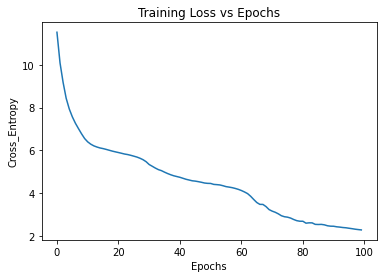

In [294]:
p2=plt.plot(train_loss_history)
plt.title("Training Loss vs Epochs")
plt.xlabel('Epochs')
plt.ylabel('Cross_Entropy')
plt.show()

In [295]:
prediction = model.predict(X_test)  # prediction of test data
prediction = np.argmax(prediction, axis=1)  # reverse one-hot encoding
testdata = np.argmax(y_test, axis=1)  # reverse for target data too

from sklearn.metrics import confusion_matrix
CM = confusion_matrix(prediction, testdata)
print(CM)

[[ 915    4   20  108  176]
 [   5 1178    1    6   26]
 [   2    2 1125    3   16]
 [ 145    6    4 1019  165]
 [ 110   20   11   82  851]]


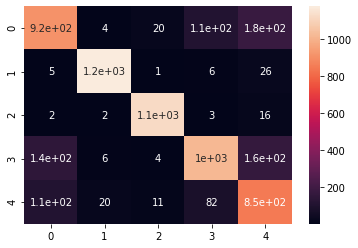

In [296]:
import seaborn
seaborn.heatmap(CM, annot=True)
plt.show()

In [297]:
print('Test Accuracy: ' + str(np.sum(np.diag(CM)) / np.sum(CM)))

Test Accuracy: 0.848
